In [85]:
import numpy as np
import yt
import unyt
from yt import YTArray
from yt.data_objects.level_sets.api import Clump, find_clumps
import argparse
import os
from astropy.table import Table
from astropy.io import ascii
import multiprocessing as multi


import datetime
from scipy import interpolate
import shutil
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as mcolors
import h5py
import trident

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl
import numpy as np
from yt.units.yt_array import YTQuantity
from scipy.ndimage import gaussian_filter
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm

def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
halo = '5036'
halo_name = halo_dict[halo]
run = 'nref11c_nref9f'
snap = 'RD0032'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)



# System and plotting settings
system = ''  # System you're using
plot = 'emission_FRB'  # Options: emission_map, emission_map_vbins, or emission_FRB or emission_FRB_binsmearing
ions = ['HI','OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']#['O VI', 'C IV', 'Si IV', 'C III', 'Si III', 'Mg II', 'Si II']#['C II','C III', 'C IV','O VI']#[
Dragonfly_limit = False
Aspera_limit = False
save_suffix = ""
file_suffix = ""


# Filtering settings (optional)
segmentation_filter='radial_velocity' # for categorizing inflow vs outflow it can also be 'metallicity'
filter_type = None  # Type of filter, e.g., 'temperature', 'density'
filter_value = None  # Value for the filter, e.g., 1e4 for temperature < 1e4 K

# Add Trident ion fields
##################################################################################################### 
def add_ion_fields(ds, ions):
    # Ensure ions is a list
    if isinstance(ions, str):
        ions = ions.split(',')  # Split the string into a list if necessary
    
    # Preprocess ions to ensure they are in the format expected by Trident
    formatted_ions = [trident_dict.get(ion, ion) for ion in ions]  
    
    trident.add_ion_fields(ds, formatted_ions)
    return ds

def scale_by_metallicity(values,assumed_Z,wanted_Z):
    # The Cloudy calculations assumed a single metallicity (typically solar).
    # This function scales the emission by the metallicity of the gas itself to
    # account for this discrepancy.
    wanted_ratio = (10.**(wanted_Z))/(10.**(assumed_Z))
    return values*wanted_ratio

def make_Cloudy_table(table_index,cloudy_path):
    # This function takes all of the Cloudy files and compiles them into one table
    # for use in the emission functions
    # table_index is the column in the Cloudy output files that is being read.
    # each table_index value corresponds to a different emission line

    # this is the the range and number of bins for which Cloudy was run
    # i.e. the temperature and hydrogen number densities gridded in the
    # Cloudy run. They must match or the table will be incorrect.

    #make sure these match the values in the Cloudy run
    hden_n_bins, hden_min, hden_max = 17, -6, 2 
    T_n_bins, T_min, T_max = 51, 3, 8 

    hden=np.linspace(hden_min,hden_max,hden_n_bins)
    T=np.linspace(T_min,T_max, T_n_bins)
    table = np.zeros((hden_n_bins,T_n_bins))
    for i in range(hden_n_bins):
            table[i,:]=[float(l.split()[table_index]) for l in open(cloudy_path%(i+1)) if l[0] != "#"]
    return hden,T,table

def make_Cloudy_table_thin(table_index,cloudy_path_thin):

    #make sure these match the values in the Cloudy run
    hden_n_bins, hden_min, hden_max = 17, -5, 2
    T_n_bins, T_min, T_max = 51, 3, 8 

    hden=np.linspace(hden_min,hden_max,hden_n_bins)
    T=np.linspace(T_min,T_max, T_n_bins)
    table = np.zeros((hden_n_bins,T_n_bins))
    for i in range(hden_n_bins):
            table[i,:]=[float(l.split()[table_index]) for l in open(cloudy_path_thin%(i+1)) if l[0] != "#"]
    return hden,T,table

def Emission_LyAlpha(field, data,scale_factor, unit_system='photons'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_LA(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10**dia1) * ((10.0**H_N)**2.0)
    
    if unit_system == 'photons':
        emission_line = emission_line / (4. * np.pi * 1.63e-11)
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    
def Emission_HAlpha(field, data,scale_factor, unit_system='photons'):
    
    H_N = np.log10(np.array(data['H_nuclei_density']))
    Temperature = np.log10(np.array(data['Temperature']))
    dia1 = bl_HA(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.**dia1) * ((10.**H_N)**2.0)
    
    if unit_system == 'photons':
        emission_line = emission_line / (4. * np.pi * 3.03e-12)
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
def Emission_CII_1335(field, data,scale_factor, unit_system='photons'):
    
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_CII_1335(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    if scale_factor > 1:
        emission_line = scale_factor * ((10.0**dia1) * ((10.0**H_N)**2.0))
    else:
        emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'photons':
        emission_line = emission_line / (4. * np.pi * 2.03e-11)
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
        
def Emission_CIII_1910(field, data,scale_factor, unit_system='photons'):
    
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_CIII_1910(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    if scale_factor > 1:
        emission_line = scale_factor * ((10.0**dia1) * ((10.0**H_N)**2.0))
    else:
        emission_line = ((10.0**dia1) * ((10.0**H_N)**2.0))
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'photons':
        emission_line = emission_line / (4. * np.pi * 2.03e-11)
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    
def Emission_CIV_1548(field, data,scale_factor, unit_system='photons'):
    
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_CIV_1548(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    if scale_factor > 1:
        emission_line = scale_factor * ((10.0**dia1) * ((10.0**H_N)**2.0))
    else:
        emission_line = ((10.0**dia1) * ((10.0**H_N)**2.0))
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'photons':
        emission_line = emission_line / (4. * np.pi * 1.28e-11)
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT

def Emission_OVI(field, data,scale_factor, unit_system='photons'):
    
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_OVI_1(H_N, Temperature)
    dia2 = bl_OVI_2(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    dia2[idx] = -200.
    if scale_factor > 1:
        emission_line = scale_factor * ((10.0**dia1) + (10**dia2)) * ((10.0**H_N)**2.0)
    else:
        emission_line = ((10.0**dia1) + (10**dia2)) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'photons':
        emission_line = emission_line / (4. * np.pi * 1.92e-11)
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10 # convert sr to arcsec^2
        return emission_line * ytEmUALT

def Emission_SiIII_1207(field, data,scale_factor, unit_system='photons'):
    
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIII_1207(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    if scale_factor > 1:
        emission_line = scale_factor * (10.0**dia1) * ((10.0**H_N)**2.0)
    else:
        emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'photons':
        emission_line = emission_line / (4. * np.pi * 1.65e-11)
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT

def Emission_SiII_1260(field, data,scale_factor, unit_system='photons'):
    
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiII_1260(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    if scale_factor > 1:
        emission_line = scale_factor * (10.0**dia1) * ((10.0**H_N)**2.0)
    else:
        emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'photons':
        emission_line = emission_line / (4.*np.pi*1.10e-11)
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")

def Emission_SiIV_1394(field, data,scale_factor, unit_system='photons'):
    
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIV_1394(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    if scale_factor > 1:
        emission_line = scale_factor * (10.0**dia1) * ((10.0**H_N)**2.0)
    else:
        emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'photons':
        emission_line = emission_line / (4.*np.pi*1.43e-11)
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")

def Emission_MgII_2796(field, data,scale_factor, unit_system='photons'):
    
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_MgII_2796(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    if scale_factor > 1:
        emission_line = scale_factor * (10.0**dia1) * ((10.0**H_N)**2.0)
    else:
        emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'photons':
        emission_line = emission_line / (4.*np.pi*7.11e-12) 
        return emission_line * ytEmU
    elif unit_system == 'erg':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT


def emission_temp(ds):
    # Extract the fields: 'Emission_CIV_1548' and 'temperature'
    ad = ds.all_data()

    save_path = prefix + f'emission_temp_plots/'
    os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists
    cmap = mtcm.get_cmap('Set1', 10)  # Colormap for plots
    ion_label_list = ['OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']
    # Create a single figure for all histograms
    plt.figure(figsize=(6.4, 4.8))

    for i, (ion, ion_label) in enumerate(zip(ions, ion_label_list)):
        print(ion)

        color = cmap(i)

        # Extract temperature and emission fields
        temperature_field = ad[('gas', 'temperature')]
        emission_field = ad[('gas', 'Emission_' + ions_dict[ion])]
        H_N = np.log10(np.array(ad['gas',"H_nuclei_density"]))

        # Convert fields to numpy arrays for plotting
        temperature_values = temperature_field.v
        emission_values = emission_field.v

        # Filter out invalid data
        valid_indices = (emission_values > 1e-40) & (temperature_values > 1e-40)
        emission_values = emission_values[valid_indices]
        temperature_values = np.log10(temperature_values[valid_indices])

        # Create bins for temperature
        #bins = np.logspace(np.log10(temperature_values.min()), np.log10(temperature_values.max()), 64)
        bins = np.linspace(temperature_values.min(), temperature_values.max(), 64)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # Compute the total emissivity for each temperature bin
        bin_indices = np.digitize(temperature_values, bins)
        emissivity_per_bin = [emission_values[bin_indices == j].sum() for j in range(1, len(bins))]

        # Plot 1D histogram using step plot
        plt.step(bin_centers, emissivity_per_bin, where='mid', color=color, label=f'{ion_label} ')

    # Set up plot scales and labels
    #plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-22, 1e-9)
    plt.xlim(3, 8)
    plt.xlabel('log(Temperature [K])',fontsize=16)
    plt.ylabel('Emissivity [$photon/s/cm^{3}/sr$]',fontsize=16)
    # Adjust tick size
    plt.tick_params(axis='both', which='major', labelsize=14)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=12)  # Minor ticks
    plt.legend()

    # Save and show the single plot
    plt.tight_layout()
    plt.grid(color='gray', linestyle='--', linewidth=0.1)
    plt.savefig(save_path + f'emission_temp_{halo_name}.png')
    plt.show()
    plt.close()

def emission_nh(ds):
    # Extract the fields: 'Emission_CIV_1548' and 'temperature'
    ad = ds.all_data()

    save_path = prefix + f'emission_temp_plots/'
    os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists
    cmap = mtcm.get_cmap('Set1', 10)  # Colormap for plots
    ion_label_list = ['OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']
    # Create a single figure for all histograms
    plt.figure(figsize=(6.4, 4.8))

    for i, (ion, ion_label) in enumerate(zip(ions, ion_label_list)):
        print(ion)

        color = cmap(i)

        # Extract temperature and emission fields
        temperature_field = ad[('gas', 'temperature')]
        emission_field = ad[('gas', 'Emission_' + ions_dict[ion])]
        nh_filed = ad['gas','H_nuclei_density']

        # Convert fields to numpy arrays for plotting
        nh_values = nh_filed.v
        emission_values = emission_field.v

        # Filter out invalid data
        valid_indices = (emission_values > 1e-40) & (nh_values > 1e-40)
        emission_values = emission_values[valid_indices]
        nh_values = np.log10(nh_values[valid_indices])

        # Create bins for temperature
        #bins = np.logspace(np.log10(temperature_values.min()), np.log10(temperature_values.max()), 64)
        bins = np.linspace(nh_values.min(), nh_values.max(), 64)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # Compute the total emissivity for each temperature bin
        bin_indices = np.digitize(nh_values, bins)
        emissivity_per_bin = [emission_values[bin_indices == j].sum() for j in range(1, len(bins))]

        # Plot 1D histogram using step plot
        plt.step(bin_centers, emissivity_per_bin, where='mid', color=color, label=f'{ion_label} ')

    # Set up plot scales and labels
    #plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-22, 1e-9)
    #plt.xlim(3, 8)
    plt.xlabel('log(nh [cm$^{-2}$])',fontsize=16)
    plt.ylabel('Emissivity [$photon/s/cm^{3}/sr$]',fontsize=16)
    # Adjust tick size
    plt.tick_params(axis='both', which='major', labelsize=14)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=12)  # Minor ticks
    plt.legend()

    # Save and show the single plot
    plt.tight_layout()
    plt.grid(color='gray', linestyle='--', linewidth=0.1)
    plt.savefig(save_path + f'emission_nh_{halo_name}.png')
    plt.show()
    plt.close()

    #############################
    import numpy as np


########################################################################################
def plot_t_ion_numdensity_2d_for_ions(
    ds,
    ions,
    ions_dict,
    label_dict,
    halo_name,
    save_dir,
    nbins=128,
    cmap_name="plasma",
    t_range=(1.0, 8.0),     # log10 K
    nh_range=(-6.0, 2.0),   # log10 cm^-3
    filename="plot_t_ion_numdensity_2d_for_ions.png",
    vmin=None,          
    vmax=None
):
    """
    Make an 8-panel (2x4) figure with 2D histograms of log10(T) vs log10(n_H)
    for each ion, weighted by that ion's emissivity.

    Parameters
    ----------
    ds : yt dataset
    ions : list[str]
        e.g. ['HI','OVI','CIV','SiIV','CIII','SiIII','MgII','SiII']
    ions_dict : dict
        maps display ion keys to field suffixes, e.g. {'OVI':'OVI', 'CIV':'CIV_1548', ...}
    label_dict : dict
        pretty labels for titles
    halo_name : str
    save_dir : str
        directory to save figure
    nbins : int
        number of bins per axis for the 2D hist
    cmap_name : str
        matplotlib colormap name (default 'plasma')
    t_range, nh_range : tuple
        axis limits in log10 units
    filename : str
        output image name
    """
 
    os.makedirs(save_dir, exist_ok=True)

    ad = ds.all_data()

    # Pull primitive arrays once
    T_log = np.log10(ad[('gas', 'temperature')].v)
    

    # Bin edges
    T_edges  = np.linspace(t_range[0],  t_range[1],  nbins + 1)
    nH_edges = np.linspace(nh_range[0], nh_range[1], nbins + 1)

    # Compute histograms first to set a global color scale (LogNorm)
    hists = []
    for ion in ions:
        emis = ad[('gas', 'Emission_' + ions_dict[ion])].v
        nH_log = np.log10(ad[('gas', ions_number_density_dict[ion])].v)
        mask = (
        np.isfinite(T_log) & np.isfinite(nH_log) &
        np.isfinite(emis) & (emis > 0)   
    )

        H, _, _ = np.histogram2d(
            nH_log[mask], T_log[mask],
            bins=[nH_edges,T_edges],
            weights=emis[mask]
        )
        hists.append(H)

    # Global positive min/max for a shared LogNorm
    # (avoid zero bins by taking min over positive entries only)
    if vmin is None or vmax is None:
        positives = [H[H > 0] for H in hists if np.any(H > 0)]
        if len(positives) == 0:
            raise RuntimeError("All histograms are empty or zero-weighted.")
        vmin = vmin or min(p.min() for p in positives)
        vmax = vmax or max(H.max() for H in hists)

    # ---- Layout (2 rows x 4 cols for 8 panels) ----
    nrows, ncols = 2, 4   # change to (2, 8) if you literally want 16 panels
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 7), constrained_layout=False)
    axes = np.atleast_2d(axes)
    plt.subplots_adjust(wspace=0.08, hspace=0.15)

    cmap = plt.get_cmap(cmap_name)

    # Plot
    for i, ion in enumerate(ions):
        r = i // ncols
        c = i % ncols
        ax = axes[r, c]

        H = hists[i]
        # imshow expects [y, x]; our H is [T, nH] because we histogrammed (T, nH)
        # We'll transpose so x=log T (horizontal), y=log nH (vertical).
        im = ax.imshow(
            H.T,
            origin='lower',
            extent=[nH_edges[0], nH_edges[-1], T_edges[0], T_edges[-1]],
            aspect='auto',
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap
        )

        
        ax.set_title(label_dict.get(ion, ion), fontsize=12)

        # --- limits and labels (swap to match axes) ---
        ax.set_xlim(*nh_range)             
        ax.set_ylim(*t_range)              

        if c == 0:
            ax.set_ylabel(r'$\log_{10}(T\,[\mathrm{K}])$', fontsize=11)
        else:
            ax.set_yticklabels([])

        if r == nrows - 1:
            ax.set_xlabel(r'$\log_{10}(n\,[\mathrm{cm}^{-3}])$', fontsize=11)
        else:
            ax.set_xticklabels([])


        # Thicker spines, small ticks
        for spine in ax.spines.values():
            spine.set_linewidth(1.6)
        ax.tick_params(axis='both', which='both', labelsize=9, length=4)

    # One shared colorbar
    cbar = fig.colorbar(
        im, ax=axes.ravel().tolist(), fraction=0.025, pad=0.02
    )
    cbar.set_label(r'Emissivity', fontsize=11)

    
    outpath = os.path.join(save_dir, filename)
    fig.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"Saved: {outpath}")

#####################################################
########################################################################################
def plot_t_nh_2d_for_ions(
    ds,
    ions,
    ions_dict,
    label_dict,
    halo_name,
    save_dir,
    nbins=128,
    cmap_name="plasma",
    t_range=(1.0, 8.0),     # log10 K
    nh_range=(-6.0, 2.0),   # log10 cm^-3
    filename="plot_t_nh_2d_for_ions.png",
    vmin=None,          
    vmax=None
):
    """
    Make an 8-panel (2x4) figure with 2D histograms of log10(T) vs log10(n_H)
    for each ion, weighted by that ion's emissivity.

    Parameters
    ----------
    ds : yt dataset
    ions : list[str]
        e.g. ['HI','OVI','CIV','SiIV','CIII','SiIII','MgII','SiII']
    ions_dict : dict
        maps display ion keys to field suffixes, e.g. {'OVI':'OVI', 'CIV':'CIV_1548', ...}
    label_dict : dict
        pretty labels for titles
    halo_name : str
    save_dir : str
        directory to save figure
    nbins : int
        number of bins per axis for the 2D hist
    cmap_name : str
        matplotlib colormap name (default 'plasma')
    t_range, nh_range : tuple
        axis limits in log10 units
    filename : str
        output image name
    """
 
    os.makedirs(save_dir, exist_ok=True)

    ad = ds#.all_data()

    # Pull primitive arrays once
    T_log = np.log10(ad[('gas', 'temperature')].v)
    nH_log = np.log10(ad[('gas', 'H_nuclei_density')].v)
    nH_log = np.log10(ad[('gas', 'number_density')].v)
    print('temp min',np.min(T_log),'temp max',np.max(T_log))
    print('nh min',np.min(nH_log),'nh max',np.max(nH_log))
    

    # Bin edges
    T_edges  = np.linspace(t_range[0],  t_range[1],  nbins + 1)
    nH_edges = np.linspace(nh_range[0], nh_range[1], nbins + 1)

    # Compute histograms first to set a global color scale (LogNorm)
    hists = []
    for ion in ions:
        print(ad[('gas', 'Emission_' + ions_dict[ion])])
        print('min emis',np.min(ad[('gas', 'Emission_' + ions_dict[ion])].v),'max emis',np.max(ad[('gas', 'Emission_' + ions_dict[ion])].v))
        emis = ad[('gas', 'Emission_' + ions_dict[ion])].v
        emis[emis <= 0] = 1e-300

        

        H, _, _ = np.histogram2d(
            nH_log, T_log,
            bins=[nH_edges,T_edges],
            weights=emis
        )
        hists.append(H)

    # Global positive min/max for a shared LogNorm
    # (avoid zero bins by taking min over positive entries only)
    if vmin is None or vmax is None:
        positives = [H[H > 0] for H in hists if np.any(H > 0)]
        if len(positives) == 0:
            raise RuntimeError("All histograms are empty or zero-weighted.")
        vmin = vmin or min(p.min() for p in positives)
        vmax = vmax or max(H.max() for H in hists)

    # ---- Layout (2 rows x 4 cols for 8 panels) ----
    nrows, ncols = 2, 4   
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 7), constrained_layout=False)
    axes = np.atleast_2d(axes)
    plt.subplots_adjust(wspace=0.08, hspace=0.15)

    cmap = plt.get_cmap(cmap_name)

    # Plot
    for i, ion in enumerate(ions):
        r = i // ncols
        c = i % ncols
        ax = axes[r, c]

        H = hists[i]
        # imshow expects [y, x]; our H is [T, nH] because we histogrammed (T, nH)
        # We'll transpose so x=log T (horizontal), y=log nH (vertical).
        im = ax.imshow(
            H.T,
            origin='lower',
            extent=[nH_edges[0], nH_edges[-1], T_edges[0], T_edges[-1]],
            aspect='auto',
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap
        )

        
        ax.set_title(label_dict.get(ion, ion), fontsize=14,weight='bold')

        # --- limits and labels (swap to match axes) ---
        ax.set_xlim(*nh_range)             
        ax.set_ylim(*t_range)       
        # --- Axis ticks and labels control ---
        if c != 0:
            ax.set_yticklabels([])   # hide y tick labels for all but first column
        else:
            ax.tick_params(labelleft=True)  # keep left column tick labels

        if r != nrows - 1:
            ax.set_xticklabels([])   # hide x tick labels for all but bottom row
        else:
            ax.tick_params(labelbottom=True)  # keep bottom row tick labels

        ax.tick_params(axis='both', labelsize=16, length=8, width=2)
          
        
        fig.text(0.5, 0.01, r'$\log_{10}(n\,[\mathrm{cm}^{-3}])$', 
                ha='center', fontsize=20)
        fig.text(0.08, 0.5, r'$\log_{10}(T\,[\mathrm{K}])$', 
                va='center', rotation='vertical', fontsize=20)
        

        # Thicker spines, small ticks
        for spine in ax.spines.values():
            spine.set_linewidth(1.6)

    # One shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.025, pad=0.02)
    cbar.set_label(r'Emissivity [photons s$^{-1}$ cm$^{-3}$ sr$^{-1}$]', fontsize=20)
    cbar.ax.tick_params(labelsize=14)
    
    
    outpath = os.path.join(save_dir, filename)
    fig.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"Saved: {outpath}")

#####################################################




def load_and_calculate(snap, ions, unit_system='default', filter_type=None, filter_value=None, resolution=100):

    '''Loads the simulation snapshot and makes the requested plots, with optional filtering.'''

    # Load simulation output
    snap_name = foggie_dir + snap + '/' + snap
    
    ds, refine_box = foggie_load(snap_name, trackfile_name = trackname, do_filter_particles=True, halo_c_v_name=halo_c_v_name, disk_relative=True, correct_bulk_velocity=True)#, smooth_AM_name=smooth_AM_name)
    zsnap = ds.get_parameter('CosmologyCurrentRedshift')
    add_ion_fields(ds,ions)

    #emission_temp(ds)
    #emission_nh(ds)

    save_path = prefix + 'emission_t_nh_2d/'
    os.makedirs(save_path, exist_ok=True)
    # plot_t_ion_numdensity_2d_for_ions(
    #     ds,
    #     ions=ions, 
    #     ions_dict=ions_dict,
    #     label_dict=label_dict,
    #     halo_name=halo_name,
    #     save_dir=save_path,
    #     nbins=128,            # tweak as you like
    #     cmap_name='plasma',   # per your request
    #     t_range=(1, 8),       # match your Cloudy table
    #     nh_range=(-15, 2),
    #     filename=f't_ion_2d_{halo_name}.png',
    #     vmin=1e-40,
    #     vmax=1e-30
    # )
    plot_t_nh_2d_for_ions(
        refine_box,
        ions=ions, 
        ions_dict=ions_dict,
        label_dict=label_dict,
        halo_name=halo_name,
        save_dir=save_path,
        nbins=128,            # tweak as you like
        cmap_name='plasma',   # per your request
        t_range=(0.1, 8.5),       # match your Cloudy table
        nh_range=(-7, 2.2),
        filename=f't_nh_2d_{halo_name}.png',
        vmin=1e-25,
        vmax=1e-15
    )

        
    

if __name__ == "__main__":

    
    # if ('feedback' in run) and ('track' in run):
    #     foggie_dir = '/nobackup/jtumlins/halo_008508/feedback-track/'
    #     run_dir = run + '/'
    
    # Set directory for output location, making it if necessary
    prefix = output_dir + 'ions_halo_00' + halo + '/' + run + '/'
    if not (os.path.exists(prefix)): os.system('mkdir -p ' + prefix)
    table_loc = prefix + 'Tables/'

    print('foggie_dir: ', foggie_dir)
    catalog_dir = code_path + 'halo_infos/00' + halo + '/' + run + '/'
    halo_c_v_name = catalog_dir + 'halo_c_v'
    #smooth_AM_name = catalog_dir + 'AM_direction_smoothed'

    cloudy_path = code_path + "cgm_emission/cloudy_extended_z0_selfshield/TEST_z0_HM12_sh_run%i.dat"
    cloudy_path_thin = code_path + "cgm_emission/cloudy_z0_HM05/bertone_run%i.dat"
    #code_path + "emission/cloudy_z0_selfshield/sh_z0_HM12_run%i.dat"
    #"/Users/vidasaeedzadeh/Documents/02-Projects/02-FOGGIE/Cloudy-runs/outputs/test-z0/TEST_z0_HM12_sh_run%i.dat"
    # These are the typical units that Lauren uses
    # NOTE: This is a volumetric unit since it's for the emissivity of each cell
    # Emission / surface brightness comes from the projections
    emission_units = 's**-1 * cm**-3 * steradian**-1'
    ytEmU = unyt.second**-1 * unyt.cm**-3 * unyt.steradian**-1

    # These are a second set of units that a lot of observers prefer
    # NOTE: This is a volumetric unit since it's for the emissivity of each cell
    # Emission / surface brightness comes from the projections
    emission_units_ALT = 'erg * s**-1 * cm**-3 * arcsec**-2'
    ytEmUALT = unyt.erg * unyt.second**-1 * unyt.cm**-3 * unyt.arcsec**-2

    ####################################
    ## BEGIN CREATING EMISSION FIELDS ##
    ####################################

    # To make the emissivity fields, you need to follow a number of steps
    # 1. Read in the Cloudy values for a given emission line
    # 2. Create the n_H and T grids that represent the desired range of values
    # 3. Set up interpolation function for the emissivity values across the grids
    #    so the code can use the n_H and T values of a simulation grid cell to
    #    interpolate the correct emissivity value
    # 4. Define the emission field for the line
    # 5. Add the line as a value in yt

    ############################
    # Function to register emission fields with unit options
    # Function to register emission fields with unit options
    def register_emission_field_with_unit(field_name, function, emission_units, unit_system,scale_factor):
        yt.add_field(
            ('gas', field_name),
            units=emission_units if unit_system == 'photons' else emission_units_ALT,
            function=lambda field, data: function(field, data,scale_factor=scale_factor, unit_system=unit_system),
            take_log=True,
            force_override=True,
            sampling_type='cell',
        )

    ####################################
    unit_system = 'photons'
    scale_factor = 0
    

    ####################################

    # H-Alpha
    hden_pts, T_pts, table_HA = make_Cloudy_table(2,cloudy_path)
    hden_pts, T_pts = np.meshgrid(hden_pts, T_pts)
    pts = np.array((hden_pts.ravel(), T_pts.ravel())).T
    
    sr_HA = table_HA.T.ravel()
    bl_HA = interpolate.LinearNDInterpolator(pts, sr_HA)
    register_emission_field_with_unit('Emission_HAlpha', Emission_HAlpha, emission_units, unit_system,scale_factor)
    
    ############################
    # Ly-Alpha
    hden_pts, T_pts, table_LA = make_Cloudy_table(1,cloudy_path)
    sr_LA = table_LA.T.ravel()
    bl_LA = interpolate.LinearNDInterpolator(pts, sr_LA)
    register_emission_field_with_unit('Emission_LyAlpha', Emission_LyAlpha, emission_units, unit_system,scale_factor)
    ############################
    # CII 1335
    hden_pts, T_pts, table_CII_1335 = make_Cloudy_table(10,cloudy_path)
    sr_CII_1335 = table_CII_1335.T.ravel()
    bl_CII_1335 = interpolate.LinearNDInterpolator(pts, sr_CII_1335)
    register_emission_field_with_unit('Emission_CII_1335', Emission_CII_1335, emission_units, unit_system,scale_factor)
    
    ############################
    # CIII 977
    # hden_pts, T_pts, table_CIII_977 = make_Cloudy_table(7,cloudy_path)
    # sr_CIII_977 = table_CIII_977.T.ravel()
    # bl_CIII_977 = interpolate.LinearNDInterpolator(pts, sr_CIII_977)
    # register_emission_field_with_unit('Emission_CIII_977', Emission_CIII_977, emission_units, unit_system,scale_factor)

    ############################
    # CIII 1910
    hden_pts, T_pts, table_CIII_1910 = make_Cloudy_table(9,cloudy_path)
    sr_CIII_1910 = table_CIII_1910.T.ravel()
    bl_CIII_1910 = interpolate.LinearNDInterpolator(pts, sr_CIII_1910)
    register_emission_field_with_unit('Emission_CIII_1910', Emission_CIII_1910, emission_units, unit_system,scale_factor)

    ############################
    # CIV 1548
    hden_pts, T_pts, table_CIV_1548 = make_Cloudy_table(3,cloudy_path)
    sr_CIV_1548  = table_CIV_1548.T.ravel()
    bl_CIV_1548  = interpolate.LinearNDInterpolator(pts, sr_CIV_1548 )
    register_emission_field_with_unit('Emission_CIV_1548', Emission_CIV_1548, emission_units, unit_system,scale_factor)
    
    ############################
    # O VI (1032 and 1038 combined)
    hden_pts, T_pts, table_OVI_1 = make_Cloudy_table(5,cloudy_path)
    hden_pts, T_pts, table_OVI_2 = make_Cloudy_table(6,cloudy_path)
    sr_OVI_1 = table_OVI_1.T.ravel()
    sr_OVI_2 = table_OVI_2.T.ravel()
    bl_OVI_1 = interpolate.LinearNDInterpolator(pts, sr_OVI_1)
    bl_OVI_2 = interpolate.LinearNDInterpolator(pts, sr_OVI_2)
    register_emission_field_with_unit('Emission_OVI', Emission_OVI, emission_units, unit_system,scale_factor)
    ############################
    # # SiII 1814
    
    # hden_pts, T_pts, table_SiII_1814 = make_Cloudy_table(11,cloudy_path)
    # sr_SiII_1814 = table_SiII_1814.T.ravel()
    # bl_SiII_1814 = interpolate.LinearNDInterpolator(pts, sr_SiII_1814)
    # register_emission_field_with_unit('Emission_SiII_1814', Emission_SiII_1814, emission_units, unit_system,scale_factor)
    # ############################
    ############################
    # SiII 1260
    
    hden_pts, T_pts, table_SiII_1260 = make_Cloudy_table(12,cloudy_path)
    sr_SiII_1260 = table_SiII_1260.T.ravel()
    bl_SiII_1260 = interpolate.LinearNDInterpolator(pts, sr_SiII_1260)
    register_emission_field_with_unit('Emission_SiII_1260', Emission_SiII_1260, emission_units, unit_system,scale_factor)
    ############################
    # SiIII 1207
    
    hden_pts, T_pts, table_SiIII_1207 = make_Cloudy_table(13,cloudy_path)
    sr_SiIII_1207 = table_SiIII_1207.T.ravel()
    bl_SiIII_1207 = interpolate.LinearNDInterpolator(pts, sr_SiIII_1207)
    register_emission_field_with_unit('Emission_SiIII_1207', Emission_SiIII_1207, emission_units, unit_system,scale_factor)
    ############################
    # SiIV 1394
    
    hden_pts, T_pts, table_SiIV_1394 = make_Cloudy_table(15,cloudy_path)
    sr_SiIV_1394 = table_SiIV_1394.T.ravel()
    bl_SiIV_1394 = interpolate.LinearNDInterpolator(pts, sr_SiIV_1394)
    register_emission_field_with_unit('Emission_SiIV_1394', Emission_SiIV_1394, emission_units, unit_system,scale_factor)
    ############################
    # MgII 2796
    
    hden_pts, T_pts, table_MgII_2796 = make_Cloudy_table(17,cloudy_path)
    sr_MgII_2796 = table_MgII_2796.T.ravel()
    bl_MgII_2796 = interpolate.LinearNDInterpolator(pts, sr_MgII_2796)
    register_emission_field_with_unit('Emission_MgII_2796', Emission_MgII_2796, emission_units, unit_system,scale_factor)
    ############################
   


    ############################
    ions_dict = {'Lyalpha':'LyAlpha', 'HI':'HAlpha', 'CII': 'CII_1335','CIII':'CIII_1910', 
                 'CIV':'CIV_1548','OVI':'OVI','SiII':'SiII_1260','SiIII':'SiIII_1207','SiIV':'SiIV_1394','MgII':'MgII_2796'}
    
    label_dict = {'Lyalpha':r'Ly-$\alpha$', 'HI':'HI', 'CII':'C II','CIII':'C III',
                'CIV':'C IV','OVI':'O VI','SiII':'Si II','SiIII':'Si III','SiIV':'Si IV','MgII':'Mg II'}
    
    trident_dict = { 'HI':'H I', 'CII':'C II','CIII':'C III',
                'CIV':'C IV','OVI':'O VI','SiII':'Si II','SiIII':'Si III','SiIV':'Si IV','MgII':'Mg II'}
    
    ions_number_density_dict = {'Lyalpha':'LyAlpha', 'HI':'H_p0_number_density', 'CII':'C_p1_number_density', 'CIII':'C_p2_number_density',
                                'CIV':'C_p3_number_density','OVI':'O_p5_number_density','SiII':'Si_p1_number_density','SiIII':'Si_p2_number_density',
                                 'SiIV':'Si_p3_number_density','MgII':'Mg_p1_number_density'}
    ions_mass_dict = {'Lyalpha':'LyAlpha', 'HI':'H_p0_mass', 'CII':'C_p1_mass', 'CIII':'C_p2_mass',
                      'CIV':'C_p3_mass','OVI':'O_p5_mass','SiII':'Si_p1_mass','SiIII':'Si_p2_mass','SiIV':'Si_p3_mass','MgII':'Mg_p1_mass'}
        

    

foggie_dir:  /Users/vidasaeedzadeh/Projects/foggie_data/halo_005036/nref11c_nref9f/


yt : [INFO     ] 2025-10-16 14:21:57,724 Parameters: current_time              = 402.3388167785
yt : [INFO     ] 2025-10-16 14:21:57,724 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-10-16 14:21:57,724 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-16 14:21:57,725 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-10-16 14:21:57,725 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-10-16 14:21:57,726 Parameters: current_redshift          = 0.49999999338561
yt : [INFO     ] 2025-10-16 14:21:57,726 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2025-10-16 14:21:57,726 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2025-10-16 14:21:57,727 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-10-16 14:21:57,727 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/vidasaeedzadeh/Projects/foggie_data/halo_005036/nref11c_nref9f/RD0032/RD0032


Parsing Hierarchy : 100%|██████████| 9191/9191 [00:00<00:00, 13487.44it/s]
yt : [INFO     ] 2025-10-16 14:21:58,508 Gathering a field list (this may take a moment.)
yt : [WARNING  ] 2025-10-16 14:21:59,677 Field ('index', 'cell_id') already exists. To override use `force_override=True`.
yt : [WARNING  ] 2025-10-16 14:21:59,678 The young_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-10-16 14:21:59,682 The young_stars3 particle filter already exists. Overriding.
yt : [WARNING  ] 2025-10-16 14:21:59,686 The young_stars8 particle filter already exists. Overriding.
yt : [WARNING  ] 2025-10-16 14:21:59,692 The old_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-10-16 14:21:59,697 The stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-10-16 14:21:59,701 The dm particle filter already exists. Overriding.


get_refine_box: using this location:       col1         col2     col3     col4    col5     col6     col7  col8
---------------- -------- -------- ------- -------- -------- ------- ----
0.50006614714632 0.472668 0.500933 0.50113 0.474668 0.502933 0.50313    9
Will look for halo_c_v_file:  /Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/halo_infos/005036/nref11c_nref9f/halo_c_v
Found halo_c_v file: /Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/halo_infos/005036/nref11c_nref9f/halo_c_v
Using halo_c_v catalog file:  /Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/halo_infos/005036/nref11c_nref9f/halo_c_v  for center style  catalog
Pulling halo center from catalog file
halo center in kpc:  [45433.22759304 48143.76669325 48168.10025385] kpc
halo velocity in km/s:  [-160.03870013   -3.98762004  -24.13242808] km/s
made it to here!
ds.halo_velocity_kms =  [-160.03870013   -3.98762004  -24.13242808] km/s  so we can add the centered velocity and energy fields
filte

yt : [WARNING  ] 2025-10-16 14:22:09,700 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-10-16 14:22:09,700 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-10-16 14:22:09,700 Field ('gas', 'H_p0_mass') already exists. Not clobbering.


found angular momentum vector
temp min 0.8600181209961759 temp max 8.441434005344137
nh min -6.340091842062778 nh max 2.385918242396986
[2.37324563e-26 2.75449233e-26 5.41788147e-26 ... 1.02699485e-25
 1.81871818e-25 2.26089658e-25] 1/(cm**3*s*sr)
min emis 1.0956538432697902e-203 max emis 4.5606941736988845e-12
[1.86697818e-25 3.53229334e-25 9.95967461e-25 ... 7.93142531e-25
 1.67001616e-24 2.21842118e-24] 1/(cm**3*s*sr)
min emis 0.0 max emis 1.2088527941478478e-13
[4.04762172e-28 8.75372808e-28 8.07072865e-27 ... 5.65405426e-26
 1.07601621e-25 1.27094715e-25] 1/(cm**3*s*sr)
min emis 0.0 max emis 1.3660422707863224e-13
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.21239652e-29
 1.67806669e-28 3.13850292e-28] 1/(cm**3*s*sr)
min emis 0.0 max emis 9.585162797836126e-14
[9.01141165e-35 2.54811569e-34 5.80161264e-33 ... 2.20437031e-31
 7.55710178e-31 1.10488215e-30] 1/(cm**3*s*sr)
min emis 0.0 max emis 9.378942410365387e-14
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.69560378e

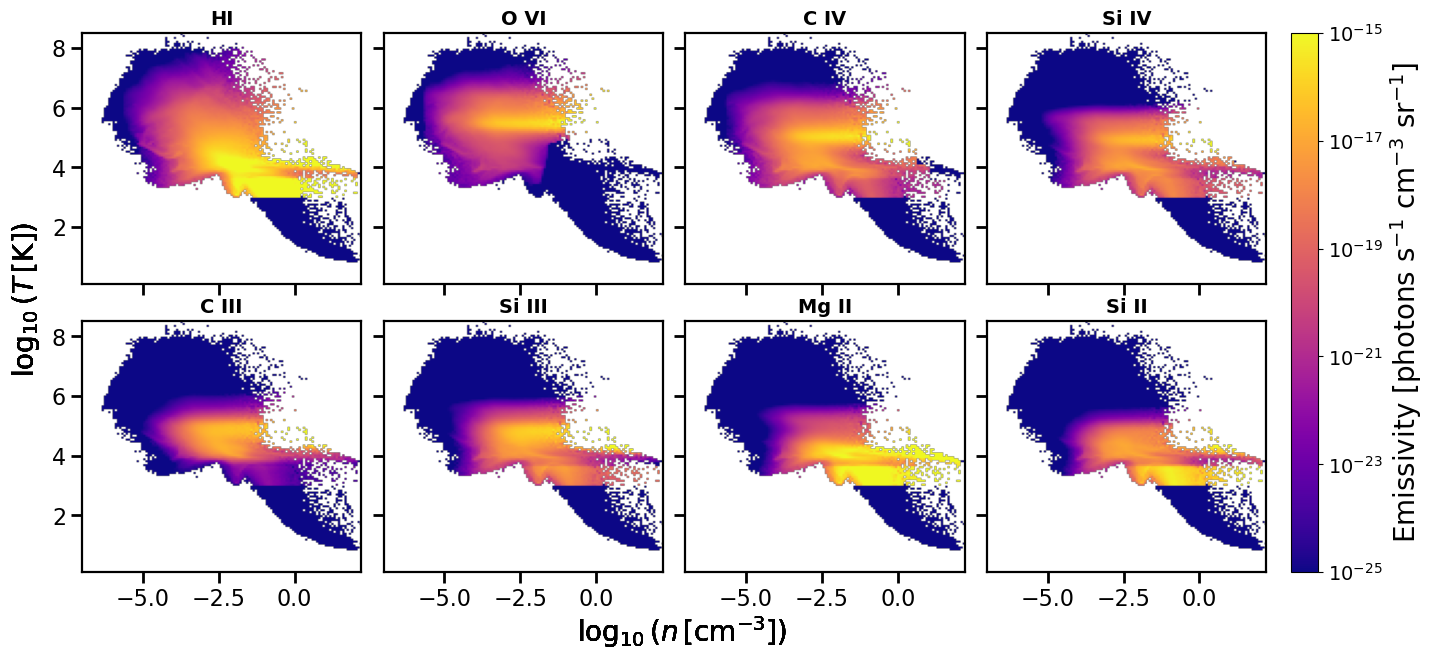

Saved: /Users/vidasaeedzadeh/Projects/foggie_outputs/ions_halo_005036/nref11c_nref9f/emission_t_nh_2d/t_nh_2d_Maelstrom.png


In [86]:
load_and_calculate(snap, ions, unit_system='photons', resolution=100) #'default'or choose 'erg' for erg unit